#Lab 4: Filtering in the Frequency Domain

Task:
* Your task is to create a Python Class `FourierFilt` that contains methods to perform the following operations:
 * Low Pass Filtering of Image `low_pass_filter` (use circle in Frequency Domain)
 * High Pass Filtering of Image `high_pass_filter` (use circle in Frequency Domain)
 * Gaussian Low Pass Filter `gaussian_filter`
 * Notch filter `notch_filter`

Notes:
> Ensure that the methods can filter a new image (rather than operating on a single image that is input during class instantitation)

> Each method should return the log of magnitude of freqeuncy domain spectrum, the mask applied in the frequency domain aswell as the filtered image (this will allow compatibility with the plotting function `plot_filters` used in the Evaluation section of the notebook)

> You may use the [numpy fft](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft) methods to perform the Discrete Fourier transforms reqired in your code.

Learning Outcomes:
* In this lab you will gain experience of performing filtering in the Frequency domain and observe how it can be used to perform standard filtering operations and be used to achieve faster filtering aswell as peform filtering that is not achievable in the spatial domain.
* You will learn to use numpy methods that perform Discreate Fourier Transforms, inverse transforms and shifting of the DFT spectrum.



In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from urllib.parse import urlparse
import math

class ImageProcessor:
    def __init__(self, save_path="./"):
        self.save_path = save_path

    def download_image(self, url):
        """
        Downloads an image from a URL and saves it to disk.
        If the image already exists, it is read from disk.

        Args:
            url (str): URL of the image.

        Returns:
            image (np.ndarray): Loaded image.
        """
        filename = os.path.basename(urlparse(url).path)
        image_path = os.path.join(self.save_path, filename)

        if os.path.exists(image_path):
            print(f"Image already exists at {image_path}. Reading from disk.")
            image = cv2.imread(image_path)
        else:
            print(f"Downloading image from {url}...")
            resp = urllib.request.urlopen(url)
            temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
            temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            cv2.imwrite(image_path, temp_image)
            print(f"Image downloaded and saved at {image_path}.")
            image = cv2.imread(image_path)
        return image

    def read_image(self, image_url, scale_factor=2):
        """
        Downloads and processes an image: scales and converts to grayscale.

        Args:
            image_url (str): URL of the image.
            scale_factor (int): Factor to downscale the image.

        Returns:
            image_scaled (np.ndarray): Scaled color image.
            gray (np.ndarray): Grayscale version.
        """
        image = self.download_image(image_url)
        x, y, z = image.shape
        image_scaled = cv2.resize(image, dsize=(int(y / scale_factor), int(x / scale_factor)), interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(image_scaled, cv2.COLOR_BGR2GRAY)
        return image_scaled, gray

    def corrupt_image(self, img):
        """
        Adds a low-amplitude sinusoidal pattern to corrupt the image.

        Args:
            img (np.ndarray): Grayscale image.

        Returns:
            op_img (np.ndarray): Corrupted image.
        """
        M, N = img.shape[1], img.shape[0]
        X, Y = np.meshgrid(np.arange(M), np.arange(N))
        k, l = 19, 20
        fxy = np.exp(2j * math.pi * (k * X / M + l * Y / N))
        mag_fxy = np.real(fxy)
        op_img = img + 100 * mag_fxy
        op_img = 255 * op_img / np.max(op_img)
        return op_img

    def plot_filters(self, image, mask, magnitude_spectrum, img_filtered, filter_type):
        """
        Plots the original image, filter mask, magnitude spectrum, and filtered image.

        Args:
            image (np.ndarray): Original image.
            mask (np.ndarray): Filter mask.
            magnitude_spectrum (np.ndarray): Log magnitude of filtered FFT.
            img_filtered (np.ndarray): Filtered image.
            filter_type (str): Type of filter applied.
        """
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.imshow(magnitude_spectrum, cmap="gray")
        plt.title("FFT Magnitude Spectrum")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.imshow(mask, cmap="gray")
        plt.title(f"{filter_type.capitalize()} Filter")
        plt.axis("off")

        plt.subplot(2, 2, 4)
        plt.imshow(img_filtered, cmap="gray")
        plt.title("Filtered Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# Create Class

Create your class `FourierFilt` in the code cell below. Some skeleton code has been inculded to guide the inputs and outputs of the methods and allow compatibility with the plotting method `plot_filters` in the ImageProcessorClass.

Notes:
> To allow compatibilty with the plot filters method (and code grade testing) your fitler methods should return (in this order), The log of the magnitude sepctrum with mask applied, the actual mask used and the final filtered image.  

 > It is assumed that the low pass filter & high pass filters will be a binary masks with a specified radius. The radius parameter is therefore sets the width of the binary mask region that could be ones or zeros.

In [4]:
class FourierFilt:
    def __init__(self):
        pass


    def low_pass_filter(self, image, radius):# Radius is size of LPF mask region
       f=np.fft.fft2(image) #converting to fourier transform
       fshift=np.fft.fftshift(f)
       rows, cols = image.shape
       mask = np.zeros_like(image)  # creating mask
       cv2.circle(mask, (cols//2, rows//2), radius, 1, -1)
       fshift_filter = fshift * mask #applying mask
       fshift_inverse = np.fft.ifftshift(fshift_filter)  #inverse filtering
       img_filtered = np.fft.ifft2(fshift_inverse)
       img_filtered = np.abs(img_filtered)
       magnitude_spectrum = np.log(1 + np.abs(fshift_filter))

       return (mask,magnitude_spectrum,img_filtered) #   log magnitude_spectrum, mask, img_filtered



    def high_pass_filter(self, image, radius):
      f=np.fft.fft2(image) #converting to fourier transform
      fshift=np.fft.fftshift(f)
      rows, cols = image.shape
      mask = np.ones_like(image)  # creating mask
      cv2.circle(mask, (cols//2, rows//2), radius, 0, -1)
      fshift_filter = fshift * mask #applying mask
      fshift_inverse = np.fft.ifftshift(fshift_filter)  #inverse filtering
      img_filtered = np.fft.ifft2(fshift_inverse)
      img_filtered = np.abs(img_filtered)
      magnitude_spectrum = np.log(1 + np.abs(fshift_filter))

      return (mask,magnitude_spectrum,img_filtered)




    def gaussian_filter(self, image, sigma):
      f=np.fft.fft2(image) #converting to fourier transform
      fshift=np.fft.fftshift(f)
      rows, cols = image.shape
      x = np.arange(cols)
      y = np.arange(rows)
      gauss_x = np.exp(-((x - cols//2)**2) / (2 * sigma**2))
      gauss_y = np.exp(-((y - rows//2)**2) / (2 * sigma**2))
      gauss_x = np.expand_dims(gauss_x, axis=0)
      gauss_y = np.expand_dims(gauss_y, axis=1)
      gaussian_mask = gauss_y @ gauss_x  # matrix multiply (outer product)
      mask3 = gaussian_mask / np.max(gaussian_mask)
      fshift_filter = fshift * mask3 #applying mask
      fshift_inverse = np.fft.ifftshift(fshift_filter)  #inverse filtering
      img_filtered = np.fft.ifft2(fshift_inverse)
      img_filtered = np.abs(img_filtered)
      magnitude_spectrum = np.log(1 + np.abs(fshift_filter))
      return (mask3,magnitude_spectrum,img_filtered)  #   log magnitude_spectrum, mask, img_filtered


    def notch_filter(self, image, notch_centers,notch_radius):
      f=np.fft.fft2(image) #converting to fourier transform
      fshift=np.fft.fftshift(f)
      rows, cols = image.shape
      mask4 = np.ones_like(image)
      for x,y in notch_centers:
        cv2.line(mask4, (x, 0), (x, rows-1), 0,notch_radius)
        cv2.line(mask4, (0, y), (cols-1, y), 0,notch_radius)
        cv2.line(mask4, (cols - x, 0), (cols - x, rows-1),0, notch_radius)
        cv2.line(mask4, (0, rows - y), (cols-1, rows - y), 0,notch_radius)
        #cv2.line(mask4, (x,y), 0, -1)
        #cv2.line(mask4, (cols - x, rows - y), 0, -1)
        #cv2.line(mask4, (cols - x, y), 0, -1)
        #cv2.line(mask4, (x, rows - y), 0, -1)
      fshift_filter = fshift * mask4 #applying mask
      fshift_inverse = np.fft.ifftshift(fshift_filter)  #inverse filtering
      img_filtered = np.fft.ifft2(fshift_inverse)
      img_filtered = np.abs(img_filtered)
      magnitude_spectrum = np.log(1 + np.abs(fshift_filter))
      return (mask4,magnitude_spectrum,img_filtered)



# Evalution
In the code cell below you can test your class performs correctly for the various methods. You can use the `plot_filters` method from the ImageProcessor class or you can create your own plots.

> Note that for most filters you can use the loaded greyscale image `'gray'`, to test your notch filter use the image `'corrupted'` which adds a sinusoidal patterns to the greyscale image.


Image already exists at ./Le_sacre_Coeur_bordercropped.jpg. Reading from disk.


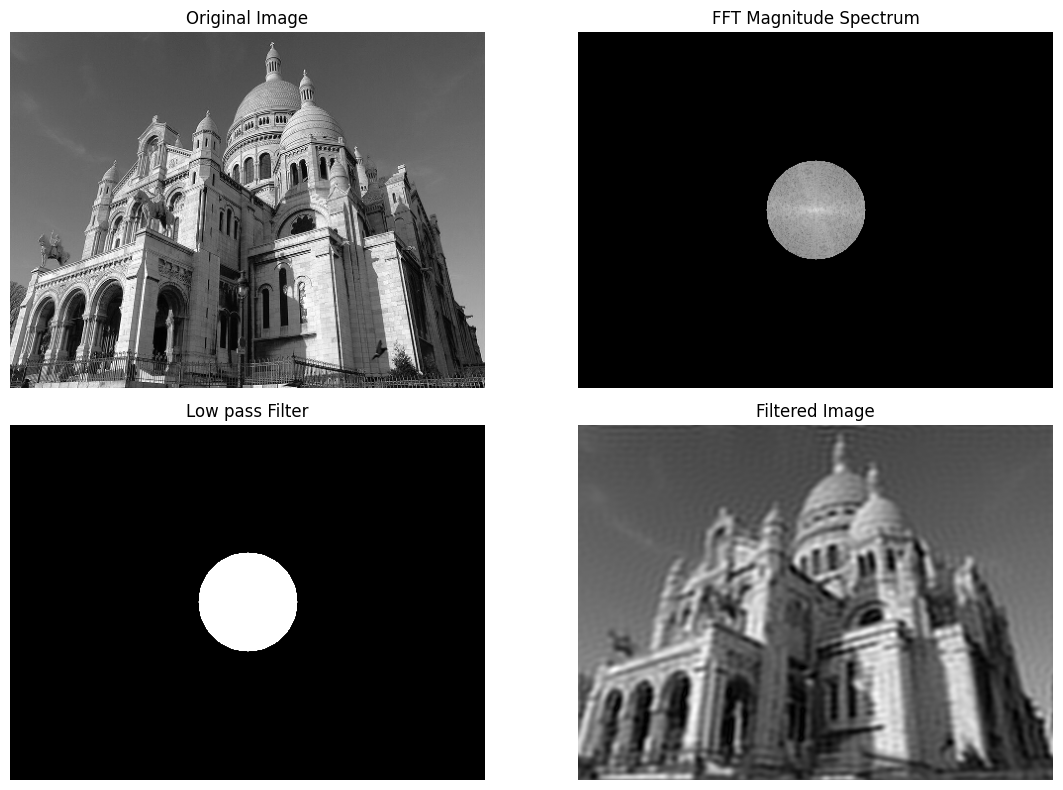

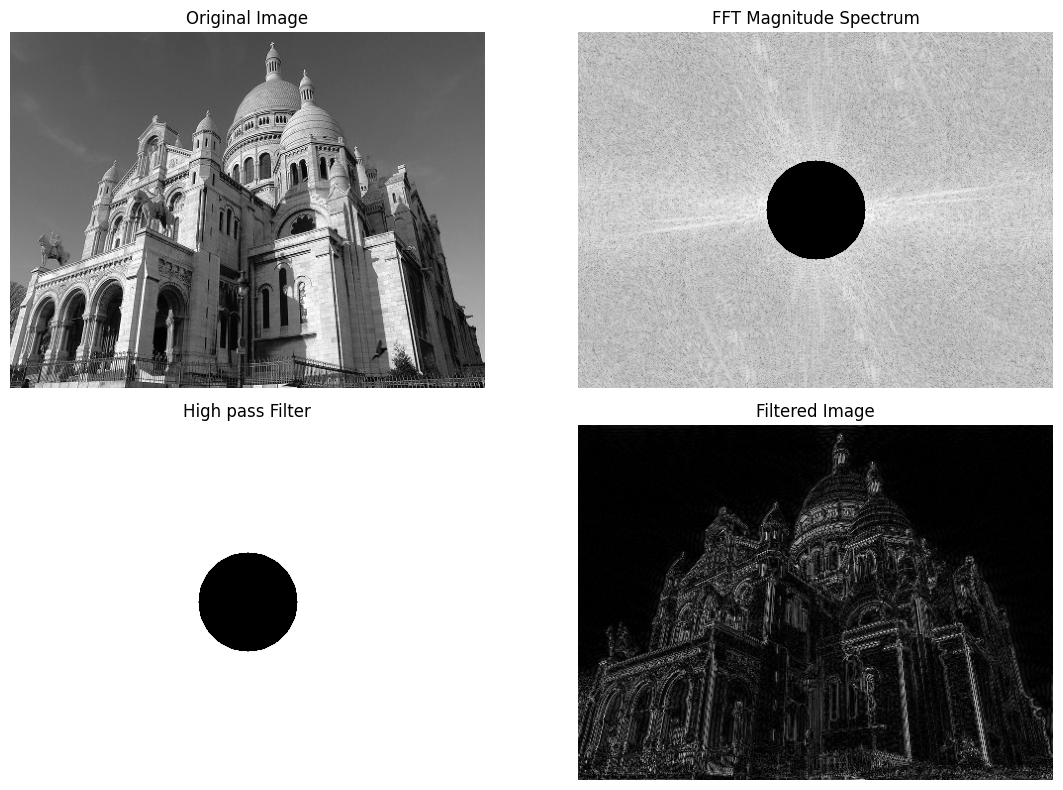

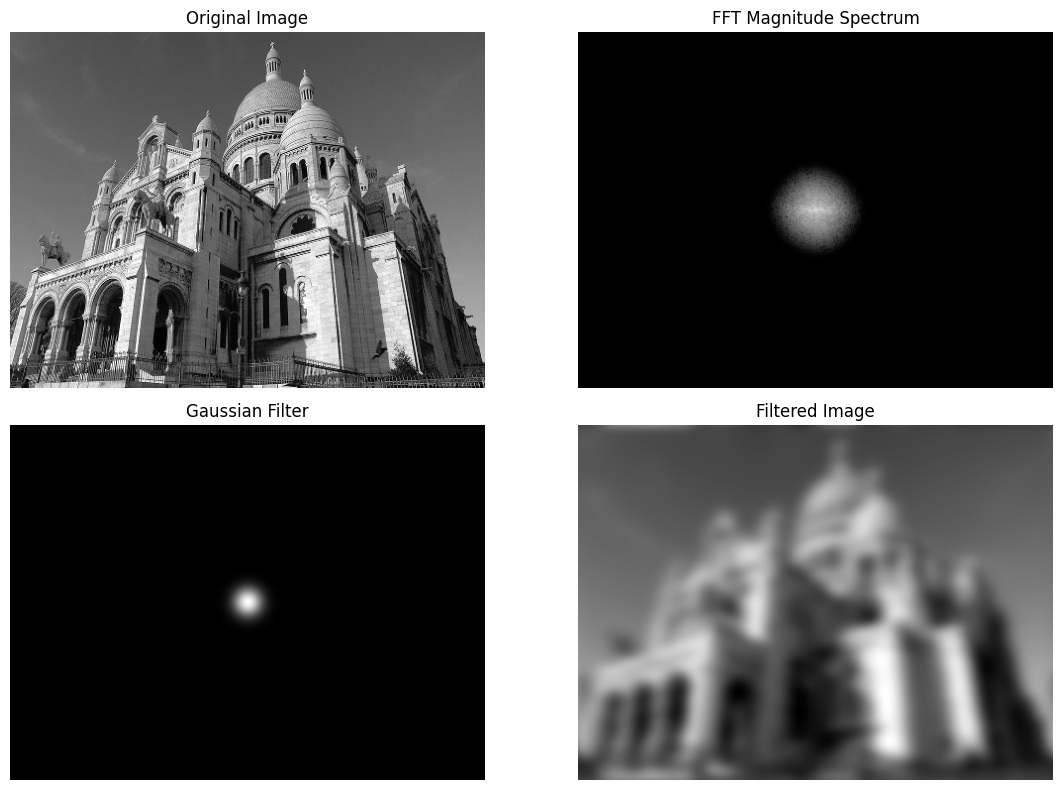

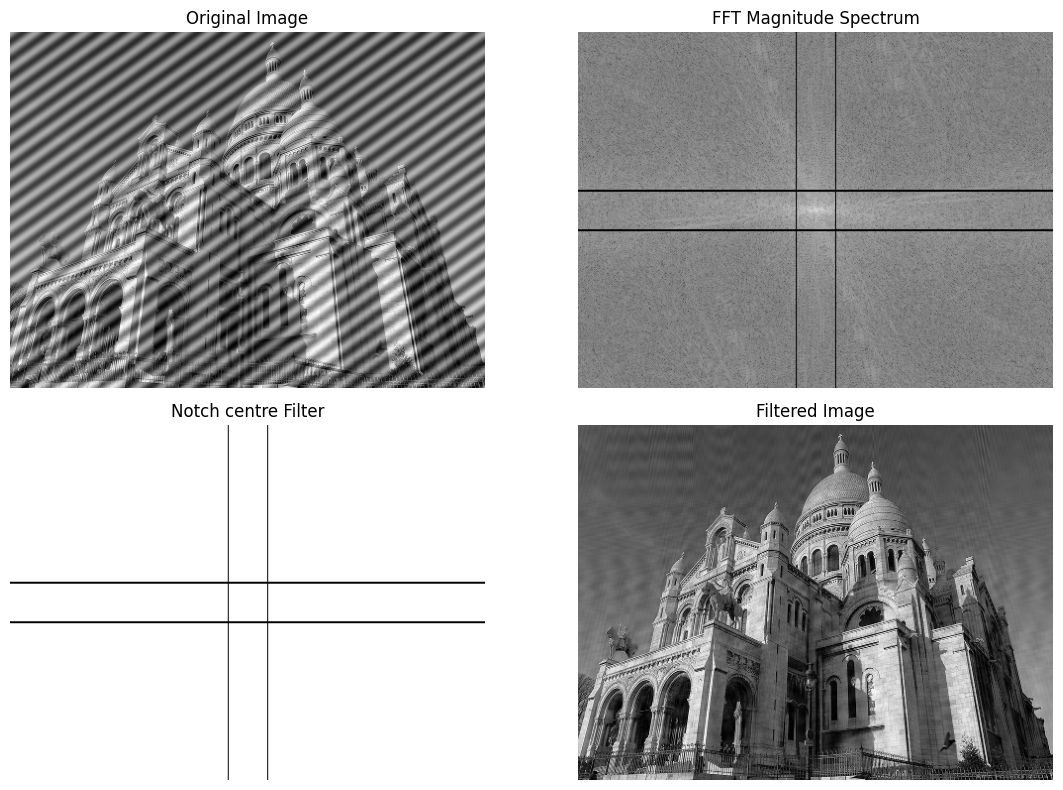

In [5]:
if __name__ == "__main__":
    # Instantiate Class
    fourier_filt = FourierFilt()
    ip = ImageProcessor()
    image_url = "https://github.com/tonyscan6003/etivities/blob/main/Le_sacre_Coeur_bordercropped.jpg?raw=true"
    # Read Image and create copies to apply to filter methods & corrupt image to notch filter
    _, gray = ip.read_image(image_url)
    gray_notch = gray.copy()
    corrupted = ip.corrupt_image(gray_notch)
    mask,magnitude_spectrum,img_filtered=fourier_filt.low_pass_filter(gray, 50)
    ip.plot_filters(gray, mask, magnitude_spectrum, img_filtered, "low pass")
    mask,magnitude_spectrum,img_filtered=fourier_filt.high_pass_filter(gray, 50)
    ip.plot_filters(gray, mask, magnitude_spectrum, img_filtered, "high pass")
    mask,magnitude_spectrum,img_filtered=fourier_filt.gaussian_filter(gray,10)
    ip.plot_filters(gray, mask, magnitude_spectrum, img_filtered, "Gaussian")
    notch_centers=[(220,160),(260,200)]
    mask,magnitude_spectrum,img_filtered=fourier_filt.notch_filter(corrupted, notch_centers,notch_radius=1)
    ip.plot_filters(corrupted, mask, magnitude_spectrum, img_filtered, "notch centre")